<a href="https://colab.research.google.com/github/mannybernabe/podcast_digest/blob/main/uplimit_course_submission_08_20_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Podcast Roundup
## Project Entry for Uplimit's Building AI Products with OpenAI

By Manny Bernabe
www.mannybernabe.com

**Back End**
I use [pipepdream](http://pipedream.com?via=manny) for this project. Pipedream takes an RSS feed, fetches most recent podcast, retrieve podcast details, transcibes podcast (AssemblyAI), summarizes podcast (OpenAI) and saves to database (google sheets).

**Front-End** I use streamit as app layer. Streamlit takes RSS Feed to process and pings database(google sheets) for latest item.

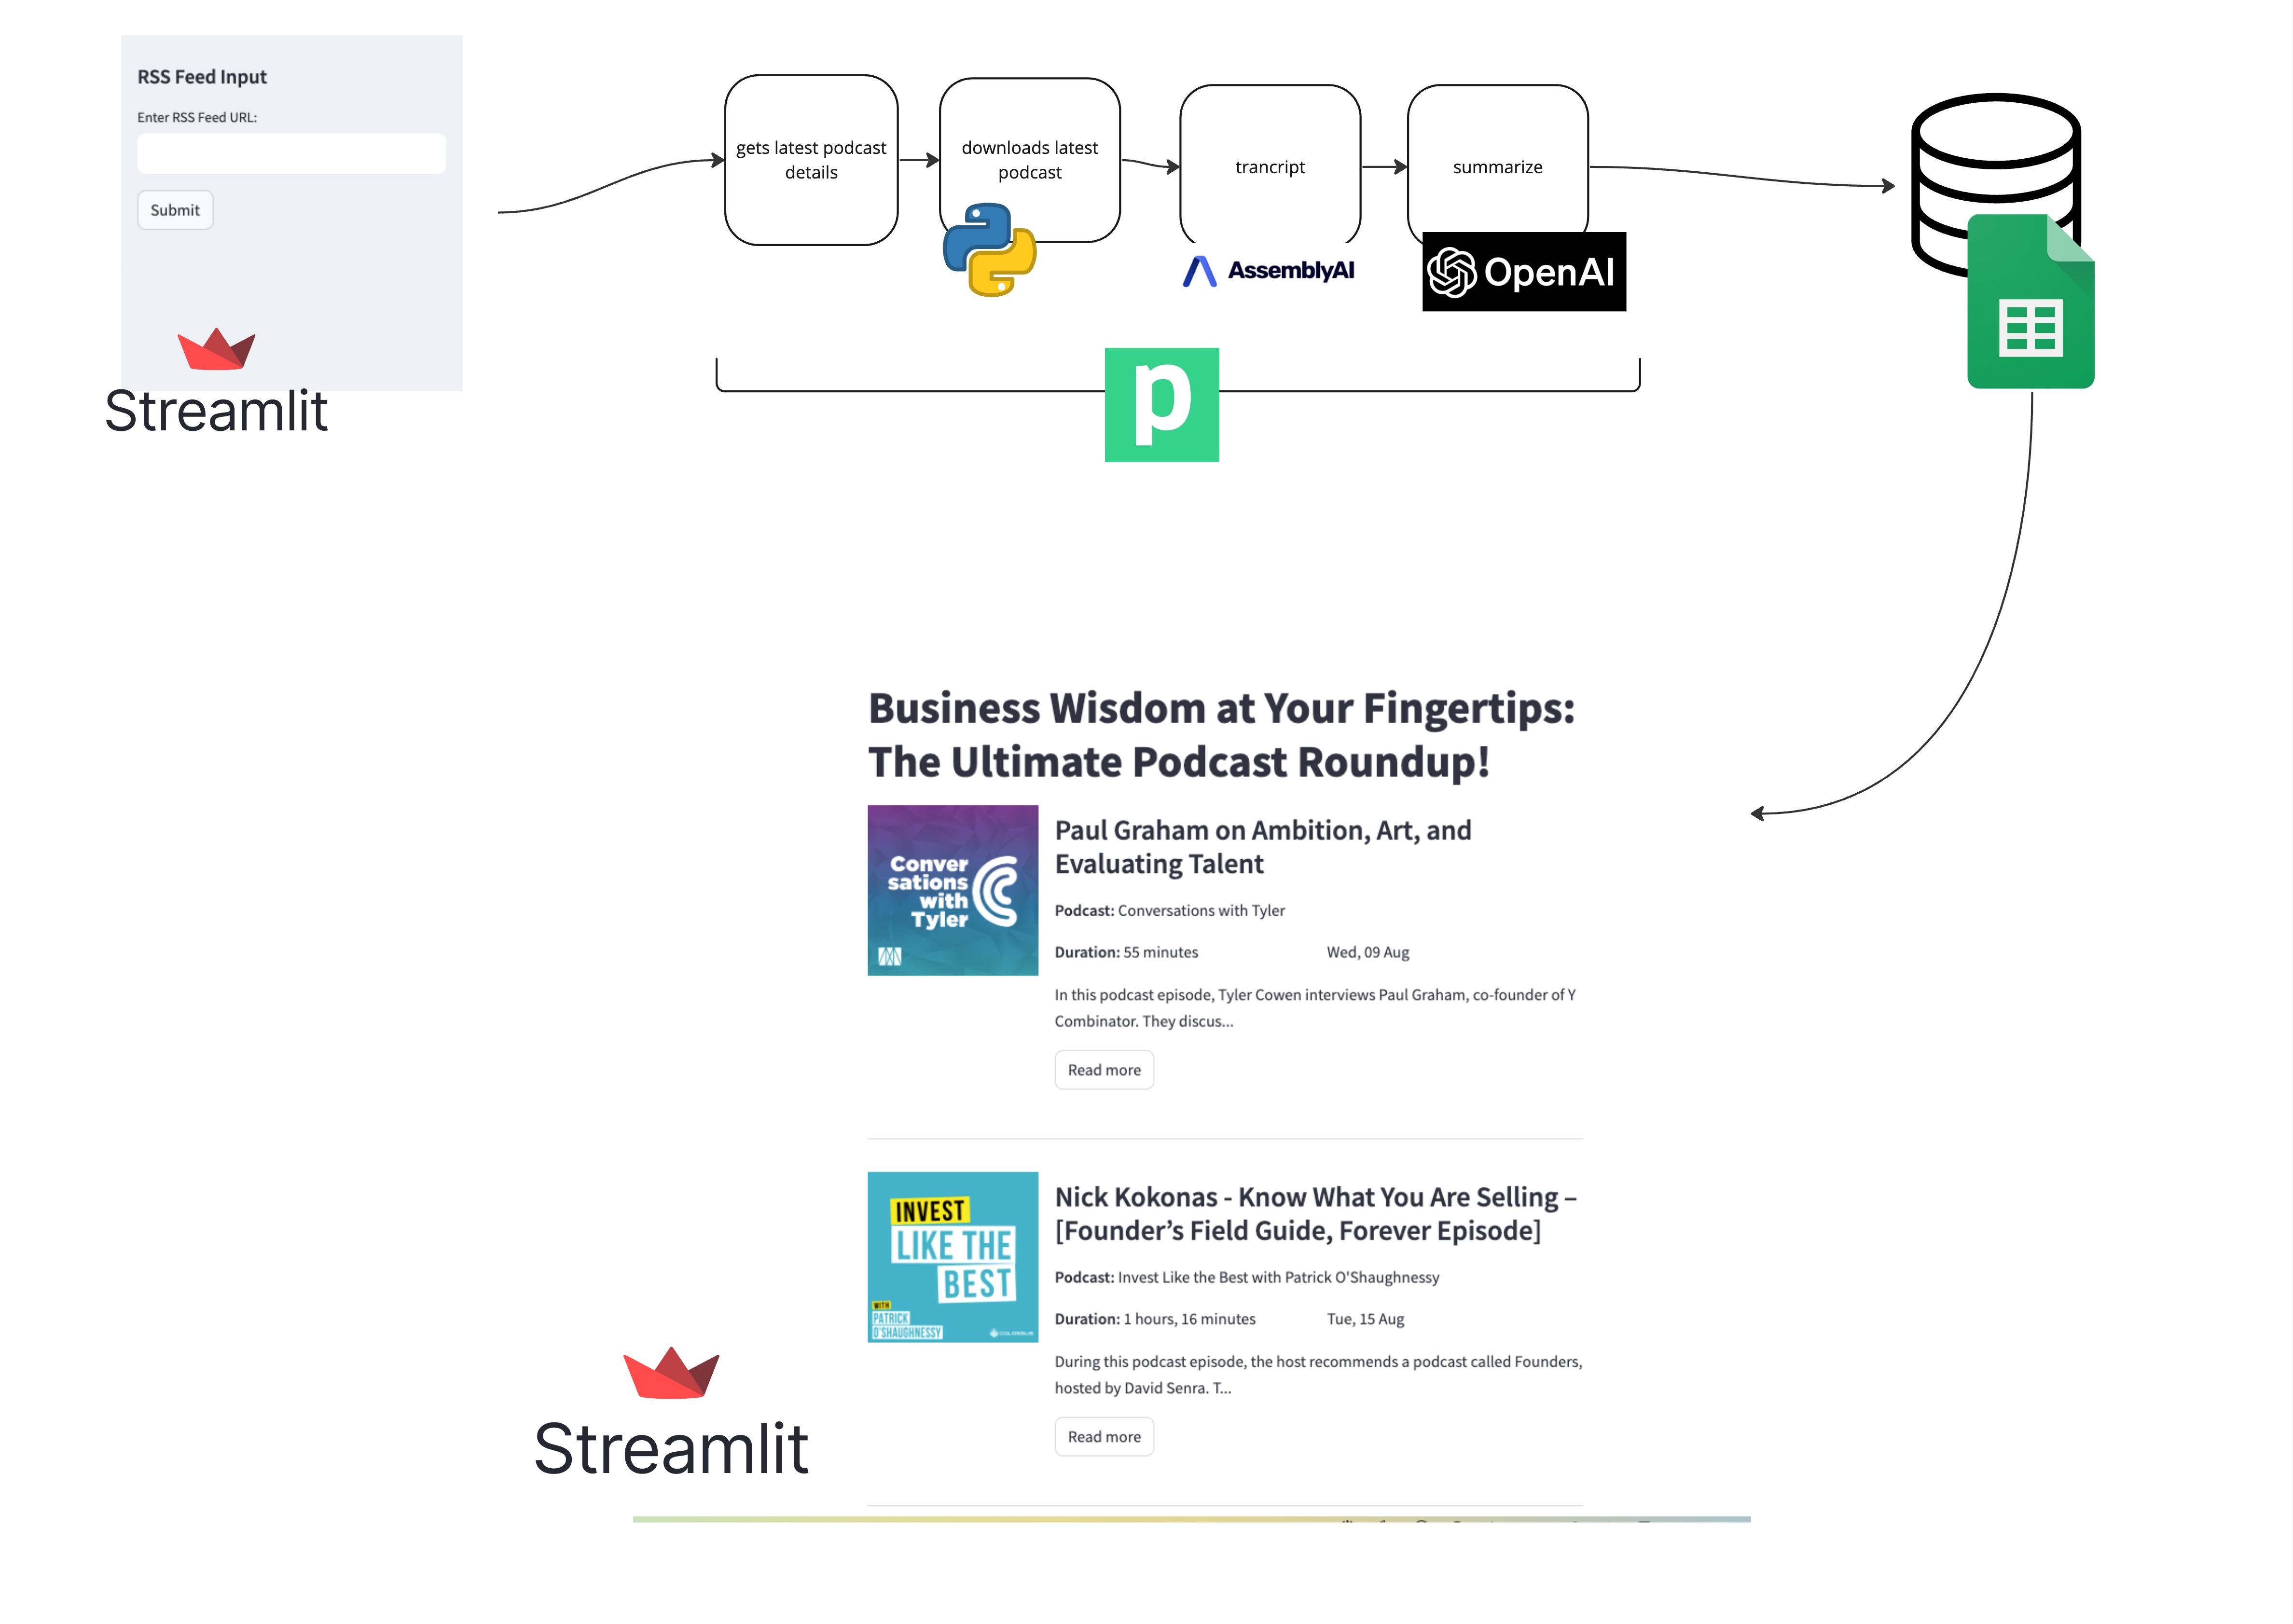

## Backend Code
Pipedream allows you to insert python nodes. Below I detail the blocks used.

In [ ]:
# Input RSS feed and outputs pod details in JSON for downstream consumption


import feedparser

def handler(pd: "pipedream"):
    podcast_feed_url = pd.steps["trigger"]["event"]["body"]["rss_URL_input"]
    podcast_feed = feedparser.parse(podcast_feed_url)

    def time_string_to_seconds(time_str):
        parts = list(map(int, time_str.split(':')))
        if len(parts) == 3:
            # HH:MM:SS format
            return parts[0] * 3600 + parts[1] * 60 + parts[2]
        elif len(parts) == 2:
            if parts[0] > 59:  # It's unlikely we have more than 59 minutes and no hours segment.
                # Pure seconds and minutes, e.g., "1234" which stands for 1234 seconds
                return parts[0] * 60 + parts[1]
            else:
                # MM:SS format
                return parts[0] * 60 + parts[1]
        elif len(parts) == 1:
            # Pure seconds
            return parts[0]
        else:
            raise ValueError(f"Unexpected time format: {time_str}")


    def seconds_to_hm(seconds):
        hours, remainder = divmod(seconds, 3600)
        minutes, _ = divmod(remainder, 60)
        if hours == 0:
            return f"{minutes} minutes"
        else:
            return f"{hours} hours, {minutes} minutes"

    for item in podcast_feed.entries[0].links:
        if item['type'] == 'audio/mpeg':
            episode_url = item.href
            title_pod = podcast_feed.entries[0].title
            pub_date = podcast_feed.entries[0].published

            podcast_name = podcast_feed.feed.title

            podcast_thumbnail = podcast_feed["feed"]["image"].href


            # Convert the duration string to seconds
            seconds = time_string_to_seconds(podcast_feed.entries[0].itunes_duration)
            formatted_time = seconds_to_hm(seconds)

            return {
                "pod_url": episode_url,
                "pod_title": title_pod,
                "pod_length": formatted_time,
                "pod_pub_date": pub_date,
                "pod_name": podcast_name,
                "pod_thumbnail":podcast_thumbnail
            }


In [ ]:
# Inputs episode URL and downloads in 8k chunks

import requests

def handler(pd: "pipedream"):
    # URL of the MP3 file
    mp3_url = pd.steps["get_pod_dets"]["$return_value"]["pod_url"]
    file_path= '/tmp/podcast_episode_rec.mp3'

    # Download the MP3 file
    r = requests.get(mp3_url, stream=True)
    r.raise_for_status()  # Raise an error if the request resulted in an HTTP error

    # Create a new file podcast_episode.mp3 in the /tmp directory
    with open(file_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):  # Download in 8K chunks
            f.write(chunk)

    results = {
    "tmpPath": file_path
    }
    return results

In [ ]:
# Sends to Assembly AI for transciption

import requests
import assemblyai as aai


def handler(pd: "pipedream"):
  aai.settings.api_key = "XXXXX"

  headers = {"authorization": f'{pd.inputs["assemblyai"]["$auth"]["api_key"]}'}
  transcriber = aai.Transcriber()
  transcript = transcriber.transcribe(pd.steps["down_load"]["$return_value"]["tmpPath"])
  # Export the data for use in future steps
  return{"pod_transcript": transcript.text}

In [ ]:
# Check token size, if too large will reduce by .15 until under limit


import tiktoken

def handler(pd: "pipedream"):
    def num_tokens_from_string(string: str, encoding_name: str) -> int:
        """Returns the number of tokens in a text string."""
        encoding = tiktoken.get_encoding(encoding_name)
        num_tokens = len(encoding.encode(string))
        return num_tokens

    text = pd.steps["assemblyai"]["$return_value"]["pod_transcript"]

    while num_tokens_from_string(text, "cl100k_base") > 17000:
        reduction_factor = 0.85  # Reduce the string length by 15%
        new_length = int(len(text) * reduction_factor)
        text = text[:new_length]

    print(num_tokens_from_string(text, "cl100k_base"))

    return {"new_pod_trans":text}

## Deployed Streamlit App
You can check out the deployed product below:

https://podcastdigest-fknngoet9qdvibqskb9lmw.streamlit.app/

## Additional Notes
I opted to go with Pipedream over Modal. I felt that Modal was too buggy and fragile. See my video updates on this to the class.

Update 1: Setting up the Back End and Using Pipe Dream 🚀
https://www.loom.com/share/809bc5bc406743299c2fb62eb1ba2b63?sid=59505331-fa0e-4a4c-aef5-44d242428466


Upate 2: Powering Streamlit w/ Pipedream ✅  [Modal❌]
https://www.loom.com/share/d1d08c5ac7db4755b8986ef13a0e8989

I ❤️ Pipedream. Check it out for yourself [HERE](http://pipedream.com?via=manny).

Thanks for checking out my project. This was fun. You can connect with me on linkedin and twitter. Cheers!

-Manny
https://www.linkedin.com/in/mannybernabe/
https://twitter.com/MannyBernabe
www.mannybernabe.com
